In [2]:
import pandas as pd
import numpy as np
import GPy

In [3]:
df = pd.read_csv("../External factor analysis.csv",index_col=0)

In [4]:
df.head()

,fiscal_month_historical,Asia sales,EMEA sales,US sales,SOX,PMI_USA,PMI_China,PMI_Singapore,PMI_Africa,PMI_Israel,...,Gold,Aluminum,Copper,Auto_S&P500,Auto_MSCI_World,Auto_MorganStanley,Auto_STOXX_Europe600,Auto_S&P_BSE,Auto_US_sales_annualized_SAAR,Auto_VDA_Germany_production
fiscal_year_historical,,,,,,,,,,,,,,,,,,,,,
2015,1,8.966216e+06,5348722.574,12208104.21,653.137,54.1,49.8,49.9,53.2,53.3,...,1283.79,1864.0,5495.0,127.99,162.27,321.93938,914.47,321.93938,16.66,427900
2015,2,1.253396e+07,6661664.538,14815130.08,714.650,53.0,49.9,49.7,47.7,48.7,...,1213.18,1815.0,5895.0,142.77,174.89,323.97543,1003.94,323.97543,16.40,501118
2015,3,1.043376e+07,3870351.629,10466013.38,695.483,51.8,50.1,49.6,47.9,50.2,...,1183.57,1785.0,6041.0,141.89,175.40,309.08361,1052.72,309.08361,17.50,556049
2015,4,9.905170e+06,5158426.383,11538538.27,686.287,51.8,50.1,49.4,44.9,49.2,...,1184.37,1925.0,6335.0,138.68,175.41,288.19900,1028.73,288.19900,16.93,479631
2015,5,1.083441e+07,7559303.469,16225844.56,745.408,52.9,50.2,50.2,50.5,47.6,...,1190.58,1740.0,6015.0,139.75,174.37,299.57748,1027.98,299.57748,17.69,447925


In [72]:
keep_ls = [
  'fiscal_month_historical',
  'US sales',
  'PMI_USA', 
  'PMI_China',
  'FX_DXY', 
  'FX_CNY',
  'Brent_spot',
  'Gold'
]

In [73]:
gp_df = df[keep_ls]
gp_df = gp_df.reset_index()
gp_df['date'] = gp_df['fiscal_year_historical'].map(str) + '-' + gp_df['fiscal_month_historical'].map(str).apply(lambda x: x.zfill(2))
gp_df['date'] = gp_df['date'].astype('datetime64[ns]')
gp_df = gp_df.drop(['fiscal_month_historical','fiscal_year_historical'],axis=1)
gp_df = gp_df.set_index('date')
gp_df.head()

,US sales,PMI_USA,PMI_China,FX_DXY,FX_CNY,Brent_spot,Gold
date,,,,,,,
2015-01-01,12208104.21,54.1,49.8,94.804,6.2505,50.77,1283.79
2015-02-01,14815130.08,53.0,49.9,95.293,6.2695,61.81,1213.18
2015-03-01,10466013.38,51.8,50.1,98.357,6.1997,53.34,1183.57
2015-04-01,11538538.27,51.8,50.1,94.600,6.2032,64.86,1184.37
2015-05-01,16225844.56,52.9,50.2,96.907,6.1976,63.89,1190.58


In [74]:
# start gaussian process regression
GPy.plotting.change_plotting_library('plotly')

In [168]:
#Y = np.array(gp_df['US sales'])
X = np.array(gp_df.drop('US sales',axis=1))
Y = gp_df['US sales'].values.reshape(X.shape[0], 1)

In [170]:
X.shape

(42, 6)

In [76]:
#define kernel
kernel = GPy.kern.RBF(input_dim=6, variance = 1., lengthscale= 1.)
m = GPy.models.GPRegression(X, Y, kernel)
m.noise

In [77]:
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [78]:
#optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 45129.625277650586
Optimization restart 2/10, f = 48176.40741180071
Optimization restart 3/10, f = 41926.89493586905
Optimization restart 4/10, f = 156364.61166155306
Optimization restart 5/10, f = 9680375.863628712
Optimization restart 6/10, f = 41757.09113199147
Optimization restart 7/10, f = 51531.67205789351
Optimization restart 8/10, f = 44936.04285556348
Optimization restart 9/10, f = 42615.25243001217
Optimization restart 10/10, f = 48865.265548927644


In [93]:
# plot
#fig = m.plot()

In [94]:
# make prediction on all past X
mu, var = m.predict(X) # return a tuple object, containing mean and variance

In [95]:
MAE = abs(mu-Y).mean()

In [98]:
# avg. percentage
MAE / Y.mean()

0.11725635311463514

In [138]:
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best', prop={'size': 6})
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [127]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(8,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [128]:
import warnings
warnings.filterwarnings('ignore')

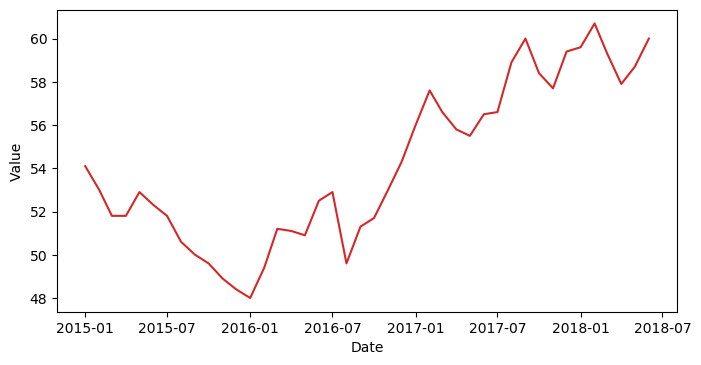

In [129]:
plot_df(gp_df,x=gp_df.index,y=gp_df['PMI_USA'])

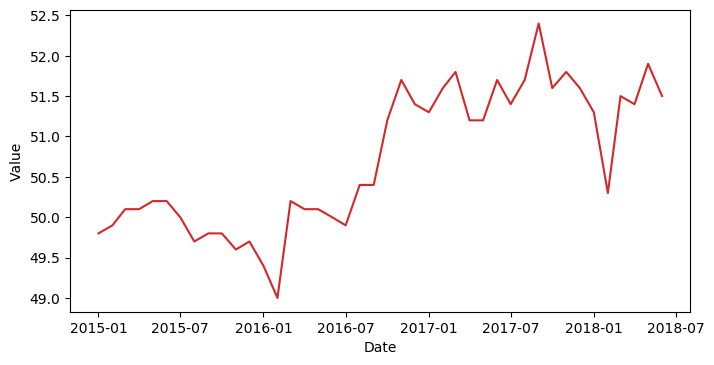

In [130]:
plot_df(gp_df,x=gp_df.index,y=gp_df['PMI_China'])

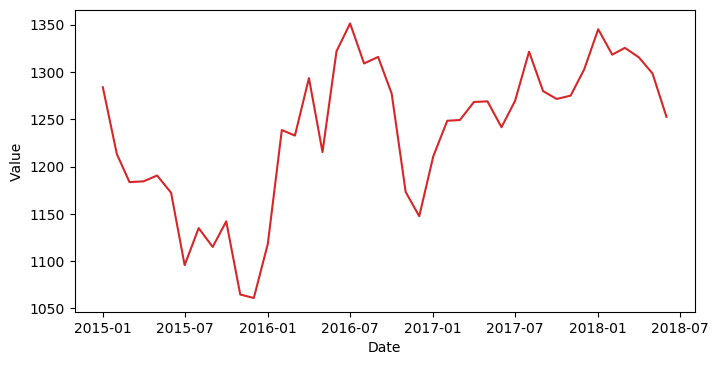

In [131]:
plot_df(gp_df,x=gp_df.index,y=gp_df['Gold'])

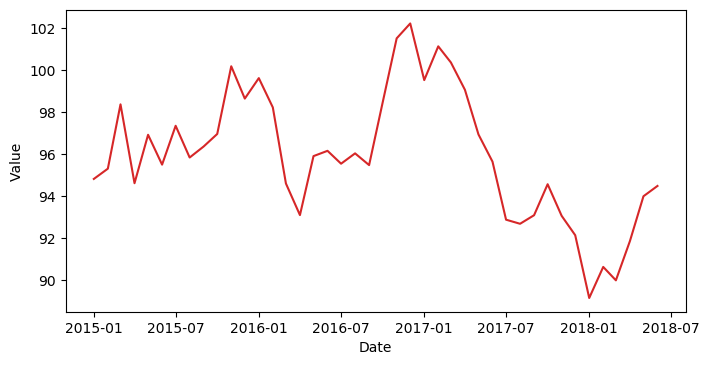

In [132]:
plot_df(gp_df,x=gp_df.index,y=gp_df['FX_DXY'])

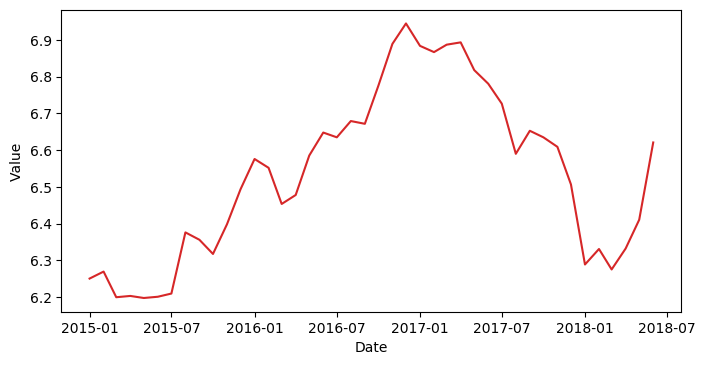

In [133]:
plot_df(gp_df,x=gp_df.index,y=gp_df['FX_CNY'])

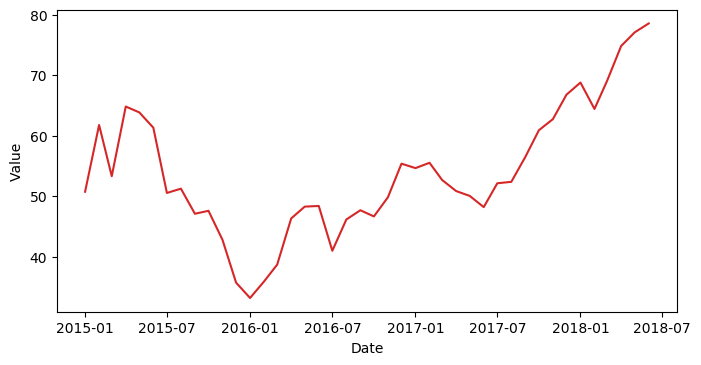

In [134]:
plot_df(gp_df,x=gp_df.index,y=gp_df['Brent_spot'])

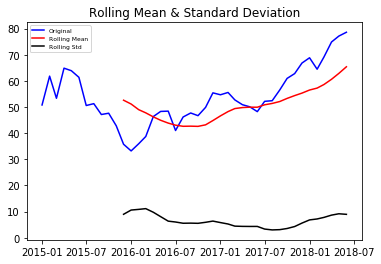

ADF Statistic: -0.4690456467540972
p-value: 0.8979168010270663
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [139]:
get_stationarity(gp_df['Brent_spot'])

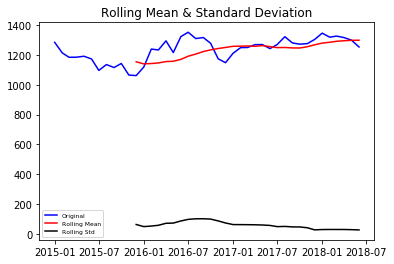

ADF Statistic: -2.055866194275218
p-value: 0.26262709827910774
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [140]:
get_stationarity(gp_df['Gold'])

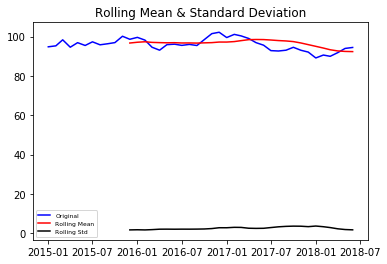

ADF Statistic: -1.9814113507437032
p-value: 0.29478257506981903
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [141]:
get_stationarity(gp_df['FX_DXY'])

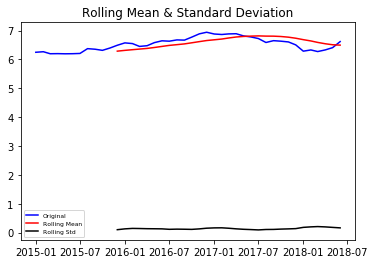

ADF Statistic: -1.6661118273763524
p-value: 0.4486517815003933
Critical Values:
	1%: -3.6055648906249997
	5%: -2.937069375
	10%: -2.606985625


In [142]:
get_stationarity(gp_df['FX_CNY'])

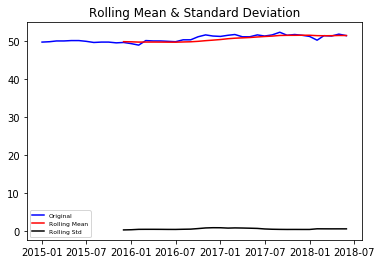

ADF Statistic: -1.717748126474457
p-value: 0.4219920862409843
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [143]:
get_stationarity(gp_df['PMI_China'])

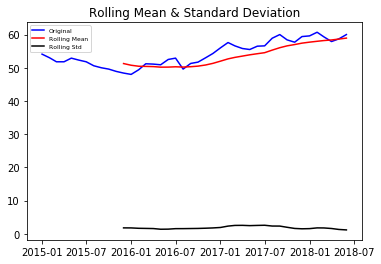

ADF Statistic: -0.4386581218844162
p-value: 0.9034414265155037
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [144]:
get_stationarity(gp_df['PMI_USA'])

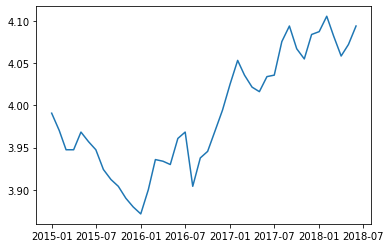

In [145]:
df_log = np.log(gp_df['PMI_USA'])
plt.plot(df_log)

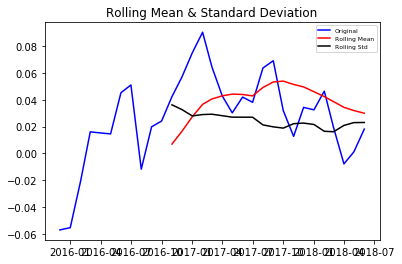

ADF Statistic: -3.6872159655720926
p-value: 0.004296608980374344
Critical Values:
	1%: -3.6790595944893187
	5%: -2.9678817237279103
	10%: -2.6231583472057074


In [146]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)    

In [152]:
df_log_pmi_usa = np.log(gp_df['PMI_USA'])
rolling_mean = df_log_pmi_usa.rolling(window=12).mean()
df_log_minus_mean_pmi_usa = df_log_pmi_usa - rolling_mean
df_log_minus_mean_pmi_usa.dropna(inplace=True)

In [153]:
df_log_pmi_china = np.log(gp_df['PMI_China'])
rolling_mean = df_log_pmi_china.rolling(window=12).mean()
df_log_minus_mean_pmi_china = df_log_pmi_china - rolling_mean
df_log_minus_mean_pmi_china.dropna(inplace=True)

In [154]:
df_log_gold = np.log(gp_df['Gold'])
rolling_mean = df_log_gold.rolling(window=12).mean()
df_log_minus_mean_gold = df_log_gold - rolling_mean
df_log_minus_mean_gold.dropna(inplace=True)

In [156]:
df_log_brent = np.log(gp_df['Brent_spot'])
rolling_mean = df_log_brent.rolling(window=12).mean()
df_log_minus_mean_brent = df_log_brent - rolling_mean
df_log_minus_mean_brent.dropna(inplace=True)

In [157]:
df_log_CNY = np.log(gp_df['FX_CNY'])
rolling_mean = df_log_CNY.rolling(window=12).mean()
df_log_minus_mean_CNY = df_log_CNY - rolling_mean
df_log_minus_mean_CNY.dropna(inplace=True)

In [158]:
df_log_DXY = np.log(gp_df['FX_DXY'])
rolling_mean = df_log_DXY.rolling(window=12).mean()
df_log_minus_mean_DXY = df_log_DXY - rolling_mean
df_log_minus_mean_DXY.dropna(inplace=True)

In [159]:
type(df_log_CNY)

pandas.core.series.Series

In [216]:
X = pd.concat([df_log_minus_mean_brent,
               df_log_minus_mean_CNY,
               df_log_minus_mean_DXY,
               df_log_minus_mean_gold,
               df_log_minus_mean_pmi_usa,
               df_log_minus_mean_pmi_china],axis=1)

In [174]:
X = np.array(X)

In [217]:
X

,Brent_spot,FX_CNY,FX_DXY,Gold,PMI_USA,PMI_China
date,,,,,,
2015-12-01,-0.372165,0.032074,0.019650,-0.082043,-0.056995,-0.004175
2016-01-01,-0.410769,0.040438,0.025369,-0.018113,-0.055324,-0.009558
2016-02-01,-0.286284,0.033109,0.008752,0.082463,-0.020713,-0.016171
2016-03-01,-0.185084,0.014632,-0.025599,0.074280,0.016047,0.007857
2016-04-01,0.022979,0.014793,-0.040280,0.115060,0.015226,0.005863
2016-05-01,0.087475,0.026179,-0.009670,0.050979,0.014516,0.006030
2016-06-01,0.109486,0.029839,-0.007618,0.125037,0.045148,0.004364
2016-07-01,-0.039149,0.022361,-0.012454,0.129555,0.050987,0.002529
2016-08-01,0.088311,0.025146,-0.007489,0.085854,-0.011762,0.011334


In [176]:
Y = Y[:31]

In [210]:
#define kernel
kernel = GPy.kern.RBF(input_dim= 6, active_dims=[0,1,2,3,4,5], ARD = True)
m = GPy.models.GPRegression(X, Y, kernel)
m.Gaussian_noise.variance = 10**(-6)
m.optimize_restarts(10, robust=True)

Optimization restart 1/10, f = 36060.606138348754
Optimization restart 2/10, f = 44533.86785966966
Optimization restart 3/10, f = 42831.459272370885
Optimization restart 4/10, f = 38962.65598005351
Optimization restart 5/10, f = 37237.355686981704
Optimization restart 6/10, f = 50644.644844513816
Optimization restart 7/10, f = 48379.71041209034
Optimization restart 8/10, f = 37874.508822162796
Optimization restart 9/10, f = 34287540666.369503
Optimization restart 10/10, f = 37005.9698825348


In [211]:
#optimize
#m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 10)

In [215]:
# make prediction on all past X
mu, var = m.predict(X) # return a tuple object, containing mean and variance
mu

array([[12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503]])

mu

In [214]:
mu

array([[12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503],
       [12927453.08491503]])

In [198]:
#gp_df['US sales']